In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import dataloader 
from tqdm import tqdm

In [2]:
import torch.nn as nn
from DeepConvNet_ReLU import DeepConvNet_ReLU
from DeepConvNet_LeakyReLU import DeepConvNet_LeakyReLU
from DeepConvNet__ELU import DeepConvNet_ELU
from EEGNet_ReLU import EEGNet_ReLU
from EEGNet_LeakyReLU import EEGNet_LeakyReLU
from EEGNet_ELU import  EEGNet_ELU

In [3]:
class BCIDataset(Dataset):

    def __init__(self, x, y= None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]
        
    def __len__(self):
        return len(self.x)

In [4]:
def show_model(model):

    for name, parameters in model.named_parameters():
        print(name, ":", parameters.size())

    print(f"\ntotal parameters {sum(p.numel() for p in model.parameters())}")

In [5]:
def trainer(model, train_loader, test_loader, config):
    
    n_epochs = config["n_epochs"]
    device = config["device"]
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= config["learning_rate"])
    
    best_acc = 0
    history = {"loss": [], "acc": [], "test_loss": [], "test_acc": []}

    early_stop = 0
    for epoch in range(n_epochs):
        early_stop += 1
        #training
        model.train()

        batch_train_loss = []
        batch_train_acc = []

        for batch in tqdm(train_loader):

            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            pred = model(features)
            loss = criterion(pred, labels.long())
            loss.backward()
            optimizer.step()

            acc = (pred.argmax(dim= -1) == labels).float().mean()

            batch_train_loss.append(loss.item())
            batch_train_acc.append(acc)


        train_loss = sum(batch_train_loss) / len(batch_train_loss)
        train_acc = sum(batch_train_acc) / len(batch_train_acc)
        history["loss"].append(train_loss)
        history["acc"].append(train_acc)

        # validation
        model.eval()
        
        batch_test_loss = []
        batch_test_acc = []

        with torch.no_grad():
            
            for batch in tqdm(test_loader):

                features, labels = batch
                labels = labels.to(device)
                test_pred = model(features.to(device))
                loss = criterion(test_pred, labels.long())
                acc = (test_pred.argmax(dim= -1) == labels).float().mean()

                batch_test_acc.append(acc)
                batch_test_loss.append(loss.item())

            test_loss = sum(batch_test_loss) / len(batch_test_loss)
            test_acc = sum(batch_test_acc) / len(batch_test_acc)
            history["test_loss"].append(test_loss)
            history["test_acc"].append(test_acc)
            
            print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f} [ Test | {epoch + 1:03d}/{n_epochs:03d} ] loss = {test_loss:.5f}, test_acc = {test_acc:.5f}")

        if test_acc > best_acc:
            print(f"Best model found at epoch {epoch}, saving model")
            torch.save(model.state_dict(), config["model_save_path"])
            best_acc = test_acc
            early_stop = 0
        if early_stop > config["early_stop"]:
            print("Early Stop!")
            break
    
    return model, history


In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda:0


In [7]:
# hyperparameter
config = {
    "n_epochs" : 400,
    "learning_rate" : 1e-2, # 1e-2
    "batch_size" : 20,
    "device" : device,
    "model" : DeepConvNet_LeakyReLU(),
    "model_name": "DeepConvNet_LeakyReLU",
    "model_save_path" : "./best.ckpt",
    "early_stop" : 150
}

In [8]:
import gc 
# load data
train_X, train_y, test_X, test_y = dataloader.read_bci_data()
print(train_X.shape, test_X.shape)

# get dataset
train_set = BCIDataset(train_X, train_y)
test_set = BCIDataset(test_X, test_y)

del train_X, train_y, test_X, test_y
gc.collect()

train_loader = DataLoader(train_set, batch_size= config["batch_size"], shuffle= True)
test_loader = DataLoader(test_set, batch_size= config["batch_size"], shuffle= False)

(1080, 1, 2, 750) (1080, 1, 2, 750)


In [9]:

model = config['model'].to(device)
config["model_save_path"] = f"./{config['model_name']}_best.ckpt"
show_model(model)


conv2d.0.weight : torch.Size([25, 1, 1, 5])
conv2d.0.bias : torch.Size([25])
conv2d.1.weight : torch.Size([25, 25, 2, 1])
conv2d.1.bias : torch.Size([25])
conv2d.2.weight : torch.Size([25])
conv2d.2.bias : torch.Size([25])
conv2d.6.weight : torch.Size([50, 25, 1, 5])
conv2d.6.bias : torch.Size([50])
conv2d.7.weight : torch.Size([50])
conv2d.7.bias : torch.Size([50])
conv2d.11.weight : torch.Size([100, 50, 1, 5])
conv2d.11.bias : torch.Size([100])
conv2d.12.weight : torch.Size([100])
conv2d.12.bias : torch.Size([100])
conv2d.16.weight : torch.Size([200, 100, 1, 5])
conv2d.16.bias : torch.Size([200])
conv2d.17.weight : torch.Size([200])
conv2d.17.bias : torch.Size([200])
conv2d.21.weight : torch.Size([330, 200, 1, 5])
conv2d.21.bias : torch.Size([330])
conv2d.22.weight : torch.Size([330])
conv2d.22.bias : torch.Size([330])
fc.0.weight : torch.Size([2, 6270])
fc.0.bias : torch.Size([2])

total parameters 477307


In [10]:
model, history = trainer(model, train_loader, test_loader, config) 

100%|██████████| 54/54 [00:00<00:00, 398.66it/s]


[ Train | 001/400 ] loss = 3.28852, acc = 0.47963 [ Test | 001/400 ] loss = 1.25668, test_acc = 0.49907
Best model found at epoch 0, saving model


100%|██████████| 54/54 [00:00<00:00, 411.59it/s]


[ Train | 002/400 ] loss = 2.20867, acc = 0.52500 [ Test | 002/400 ] loss = 1.82664, test_acc = 0.50833
Best model found at epoch 1, saving model


100%|██████████| 54/54 [00:00<00:00, 390.38it/s]


[ Train | 003/400 ] loss = 2.04888, acc = 0.52685 [ Test | 003/400 ] loss = 1.53001, test_acc = 0.53241
Best model found at epoch 2, saving model


100%|██████████| 54/54 [00:00<00:00, 424.21it/s]


[ Train | 004/400 ] loss = 1.60227, acc = 0.60741 [ Test | 004/400 ] loss = 1.75250, test_acc = 0.65741
Best model found at epoch 3, saving model


100%|██████████| 54/54 [00:00<00:00, 427.98it/s]


[ Train | 005/400 ] loss = 1.77236, acc = 0.63056 [ Test | 005/400 ] loss = 1.81123, test_acc = 0.53241


100%|██████████| 54/54 [00:00<00:00, 374.31it/s]


[ Train | 006/400 ] loss = 1.60212, acc = 0.59815 [ Test | 006/400 ] loss = 0.95084, test_acc = 0.63241


100%|██████████| 54/54 [00:00<00:00, 402.06it/s]


[ Train | 007/400 ] loss = 0.94556, acc = 0.64537 [ Test | 007/400 ] loss = 0.63337, test_acc = 0.67500
Best model found at epoch 6, saving model


100%|██████████| 54/54 [00:00<00:00, 402.64it/s]


[ Train | 008/400 ] loss = 0.70875, acc = 0.69352 [ Test | 008/400 ] loss = 0.62662, test_acc = 0.68796
Best model found at epoch 7, saving model


100%|██████████| 54/54 [00:00<00:00, 410.84it/s]


[ Train | 009/400 ] loss = 0.78451, acc = 0.66389 [ Test | 009/400 ] loss = 0.78258, test_acc = 0.68148


100%|██████████| 54/54 [00:00<00:00, 391.44it/s]


[ Train | 010/400 ] loss = 0.74146, acc = 0.67963 [ Test | 010/400 ] loss = 0.58412, test_acc = 0.69907
Best model found at epoch 9, saving model


100%|██████████| 54/54 [00:00<00:00, 368.74it/s]


[ Train | 011/400 ] loss = 0.63977, acc = 0.67778 [ Test | 011/400 ] loss = 0.55262, test_acc = 0.71296
Best model found at epoch 10, saving model


100%|██████████| 54/54 [00:00<00:00, 315.04it/s]


[ Train | 012/400 ] loss = 0.57782, acc = 0.70278 [ Test | 012/400 ] loss = 0.59702, test_acc = 0.69537


100%|██████████| 54/54 [00:00<00:00, 393.43it/s]


[ Train | 013/400 ] loss = 0.57563, acc = 0.70278 [ Test | 013/400 ] loss = 0.56706, test_acc = 0.73241
Best model found at epoch 12, saving model


100%|██████████| 54/54 [00:00<00:00, 409.19it/s]


[ Train | 014/400 ] loss = 0.58268, acc = 0.73241 [ Test | 014/400 ] loss = 0.55735, test_acc = 0.74167
Best model found at epoch 13, saving model


100%|██████████| 54/54 [00:00<00:00, 397.53it/s]


[ Train | 015/400 ] loss = 0.57421, acc = 0.71667 [ Test | 015/400 ] loss = 0.52177, test_acc = 0.75185
Best model found at epoch 14, saving model


100%|██████████| 54/54 [00:00<00:00, 386.70it/s]


[ Train | 016/400 ] loss = 0.52556, acc = 0.71296 [ Test | 016/400 ] loss = 0.51677, test_acc = 0.74167


100%|██████████| 54/54 [00:00<00:00, 391.43it/s]


[ Train | 017/400 ] loss = 0.54340, acc = 0.70741 [ Test | 017/400 ] loss = 0.51641, test_acc = 0.75278
Best model found at epoch 16, saving model


100%|██████████| 54/54 [00:00<00:00, 386.65it/s]


[ Train | 018/400 ] loss = 0.51025, acc = 0.73148 [ Test | 018/400 ] loss = 0.52800, test_acc = 0.75000


100%|██████████| 54/54 [00:00<00:00, 405.02it/s]


[ Train | 019/400 ] loss = 0.51447, acc = 0.75556 [ Test | 019/400 ] loss = 0.50151, test_acc = 0.76111
Best model found at epoch 18, saving model


100%|██████████| 54/54 [00:00<00:00, 378.10it/s]


[ Train | 020/400 ] loss = 0.52744, acc = 0.76204 [ Test | 020/400 ] loss = 0.53727, test_acc = 0.73148


100%|██████████| 54/54 [00:00<00:00, 294.12it/s]


[ Train | 021/400 ] loss = 0.51060, acc = 0.75000 [ Test | 021/400 ] loss = 0.50346, test_acc = 0.75926


100%|██████████| 54/54 [00:00<00:00, 373.56it/s]


[ Train | 022/400 ] loss = 0.50020, acc = 0.75000 [ Test | 022/400 ] loss = 0.50495, test_acc = 0.76481
Best model found at epoch 21, saving model


100%|██████████| 54/54 [00:00<00:00, 374.19it/s]


[ Train | 023/400 ] loss = 0.51887, acc = 0.74722 [ Test | 023/400 ] loss = 0.51981, test_acc = 0.76852
Best model found at epoch 22, saving model


100%|██████████| 54/54 [00:00<00:00, 387.63it/s]


[ Train | 024/400 ] loss = 0.47472, acc = 0.75833 [ Test | 024/400 ] loss = 0.53154, test_acc = 0.75556


100%|██████████| 54/54 [00:00<00:00, 372.33it/s]


[ Train | 025/400 ] loss = 0.51395, acc = 0.75278 [ Test | 025/400 ] loss = 0.49939, test_acc = 0.77500
Best model found at epoch 24, saving model


100%|██████████| 54/54 [00:00<00:00, 397.71it/s]


[ Train | 026/400 ] loss = 0.49493, acc = 0.76759 [ Test | 026/400 ] loss = 0.50968, test_acc = 0.79167
Best model found at epoch 25, saving model


100%|██████████| 54/54 [00:00<00:00, 374.82it/s]


[ Train | 027/400 ] loss = 0.51199, acc = 0.73704 [ Test | 027/400 ] loss = 0.48359, test_acc = 0.79352
Best model found at epoch 26, saving model


100%|██████████| 54/54 [00:00<00:00, 273.68it/s]


[ Train | 028/400 ] loss = 0.48774, acc = 0.75463 [ Test | 028/400 ] loss = 0.47777, test_acc = 0.78981


100%|██████████| 54/54 [00:00<00:00, 282.97it/s]


[ Train | 029/400 ] loss = 0.48908, acc = 0.75833 [ Test | 029/400 ] loss = 0.46591, test_acc = 0.80185
Best model found at epoch 28, saving model


100%|██████████| 54/54 [00:00<00:00, 344.34it/s]


[ Train | 030/400 ] loss = 0.48202, acc = 0.76759 [ Test | 030/400 ] loss = 0.46575, test_acc = 0.78704


100%|██████████| 54/54 [00:00<00:00, 204.17it/s]


[ Train | 031/400 ] loss = 0.49693, acc = 0.74815 [ Test | 031/400 ] loss = 0.48831, test_acc = 0.76019


100%|██████████| 54/54 [00:00<00:00, 291.12it/s]


[ Train | 032/400 ] loss = 0.47943, acc = 0.77037 [ Test | 032/400 ] loss = 0.48150, test_acc = 0.80093


100%|██████████| 54/54 [00:00<00:00, 360.87it/s]


[ Train | 033/400 ] loss = 0.47073, acc = 0.77407 [ Test | 033/400 ] loss = 0.45960, test_acc = 0.80278
Best model found at epoch 32, saving model


100%|██████████| 54/54 [00:00<00:00, 273.06it/s]


[ Train | 034/400 ] loss = 0.45405, acc = 0.77407 [ Test | 034/400 ] loss = 0.45320, test_acc = 0.80093


100%|██████████| 54/54 [00:00<00:00, 362.23it/s]


[ Train | 035/400 ] loss = 0.46008, acc = 0.78148 [ Test | 035/400 ] loss = 0.45370, test_acc = 0.79074


100%|██████████| 54/54 [00:00<00:00, 397.49it/s]


[ Train | 036/400 ] loss = 0.48160, acc = 0.76852 [ Test | 036/400 ] loss = 0.44233, test_acc = 0.80185


100%|██████████| 54/54 [00:00<00:00, 379.77it/s]


[ Train | 037/400 ] loss = 0.49256, acc = 0.77130 [ Test | 037/400 ] loss = 0.47391, test_acc = 0.78148


100%|██████████| 54/54 [00:00<00:00, 364.84it/s]


[ Train | 038/400 ] loss = 0.46162, acc = 0.77407 [ Test | 038/400 ] loss = 0.47958, test_acc = 0.78241


100%|██████████| 54/54 [00:00<00:00, 415.40it/s]


[ Train | 039/400 ] loss = 0.47065, acc = 0.79444 [ Test | 039/400 ] loss = 0.46368, test_acc = 0.80000


100%|██████████| 54/54 [00:00<00:00, 380.59it/s]


[ Train | 040/400 ] loss = 0.46763, acc = 0.77593 [ Test | 040/400 ] loss = 0.46047, test_acc = 0.80648
Best model found at epoch 39, saving model


100%|██████████| 54/54 [00:00<00:00, 405.65it/s]


[ Train | 041/400 ] loss = 0.46503, acc = 0.78519 [ Test | 041/400 ] loss = 0.44802, test_acc = 0.80000


100%|██████████| 54/54 [00:00<00:00, 399.26it/s]


[ Train | 042/400 ] loss = 0.46320, acc = 0.78148 [ Test | 042/400 ] loss = 0.45231, test_acc = 0.80093


100%|██████████| 54/54 [00:00<00:00, 310.48it/s]


[ Train | 043/400 ] loss = 0.46558, acc = 0.78519 [ Test | 043/400 ] loss = 0.46218, test_acc = 0.79352


100%|██████████| 54/54 [00:00<00:00, 365.57it/s]


[ Train | 044/400 ] loss = 0.44530, acc = 0.79352 [ Test | 044/400 ] loss = 0.43606, test_acc = 0.80463


100%|██████████| 54/54 [00:00<00:00, 386.52it/s]


[ Train | 045/400 ] loss = 0.45110, acc = 0.79444 [ Test | 045/400 ] loss = 0.45385, test_acc = 0.80278


100%|██████████| 54/54 [00:00<00:00, 370.27it/s]


[ Train | 046/400 ] loss = 0.43540, acc = 0.79815 [ Test | 046/400 ] loss = 0.45037, test_acc = 0.80093


100%|██████████| 54/54 [00:00<00:00, 390.64it/s]


[ Train | 047/400 ] loss = 0.44424, acc = 0.78981 [ Test | 047/400 ] loss = 0.44145, test_acc = 0.81667
Best model found at epoch 46, saving model


100%|██████████| 54/54 [00:00<00:00, 380.72it/s]


[ Train | 048/400 ] loss = 0.45380, acc = 0.78519 [ Test | 048/400 ] loss = 0.45527, test_acc = 0.80278


100%|██████████| 54/54 [00:00<00:00, 380.96it/s]


[ Train | 049/400 ] loss = 0.45076, acc = 0.79167 [ Test | 049/400 ] loss = 0.49704, test_acc = 0.76944


100%|██████████| 54/54 [00:00<00:00, 390.22it/s]


[ Train | 050/400 ] loss = 0.46022, acc = 0.79722 [ Test | 050/400 ] loss = 0.43304, test_acc = 0.81019


100%|██████████| 54/54 [00:00<00:00, 317.21it/s]


[ Train | 051/400 ] loss = 0.44734, acc = 0.80093 [ Test | 051/400 ] loss = 0.45820, test_acc = 0.79537


100%|██████████| 54/54 [00:00<00:00, 357.85it/s]


[ Train | 052/400 ] loss = 0.44136, acc = 0.80463 [ Test | 052/400 ] loss = 0.43282, test_acc = 0.79907


100%|██████████| 54/54 [00:00<00:00, 247.40it/s]


[ Train | 053/400 ] loss = 0.45169, acc = 0.80093 [ Test | 053/400 ] loss = 0.45327, test_acc = 0.79167


100%|██████████| 54/54 [00:00<00:00, 401.57it/s]


[ Train | 054/400 ] loss = 0.46866, acc = 0.78241 [ Test | 054/400 ] loss = 0.44938, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 365.23it/s]


[ Train | 055/400 ] loss = 0.44738, acc = 0.78889 [ Test | 055/400 ] loss = 0.45950, test_acc = 0.78056


100%|██████████| 54/54 [00:00<00:00, 398.07it/s]


[ Train | 056/400 ] loss = 0.44289, acc = 0.78148 [ Test | 056/400 ] loss = 0.43307, test_acc = 0.81481


100%|██████████| 54/54 [00:00<00:00, 375.39it/s]


[ Train | 057/400 ] loss = 0.43817, acc = 0.79352 [ Test | 057/400 ] loss = 0.46063, test_acc = 0.78796


100%|██████████| 54/54 [00:00<00:00, 386.60it/s]


[ Train | 058/400 ] loss = 0.46078, acc = 0.79074 [ Test | 058/400 ] loss = 0.45048, test_acc = 0.81667
Best model found at epoch 57, saving model


100%|██████████| 54/54 [00:00<00:00, 341.29it/s]


[ Train | 059/400 ] loss = 0.44773, acc = 0.79815 [ Test | 059/400 ] loss = 0.43607, test_acc = 0.80741


100%|██████████| 54/54 [00:00<00:00, 365.03it/s]


[ Train | 060/400 ] loss = 0.43982, acc = 0.80556 [ Test | 060/400 ] loss = 0.45327, test_acc = 0.80093


100%|██████████| 54/54 [00:00<00:00, 360.21it/s]


[ Train | 061/400 ] loss = 0.43668, acc = 0.79907 [ Test | 061/400 ] loss = 0.41990, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 387.67it/s]


[ Train | 062/400 ] loss = 0.44547, acc = 0.80370 [ Test | 062/400 ] loss = 0.45016, test_acc = 0.82222
Best model found at epoch 61, saving model


100%|██████████| 54/54 [00:00<00:00, 390.60it/s]


[ Train | 063/400 ] loss = 0.42978, acc = 0.80185 [ Test | 063/400 ] loss = 0.43205, test_acc = 0.80185


100%|██████████| 54/54 [00:00<00:00, 383.55it/s]


[ Train | 064/400 ] loss = 0.43250, acc = 0.78426 [ Test | 064/400 ] loss = 0.41241, test_acc = 0.80741


100%|██████████| 54/54 [00:00<00:00, 392.26it/s]


[ Train | 065/400 ] loss = 0.45368, acc = 0.79167 [ Test | 065/400 ] loss = 0.45163, test_acc = 0.77963


100%|██████████| 54/54 [00:00<00:00, 397.00it/s]


[ Train | 066/400 ] loss = 0.43976, acc = 0.80278 [ Test | 066/400 ] loss = 0.47111, test_acc = 0.75833


100%|██████████| 54/54 [00:00<00:00, 374.60it/s]


[ Train | 067/400 ] loss = 0.47783, acc = 0.77315 [ Test | 067/400 ] loss = 0.44798, test_acc = 0.80556


100%|██████████| 54/54 [00:00<00:00, 369.09it/s]


[ Train | 068/400 ] loss = 0.44187, acc = 0.80648 [ Test | 068/400 ] loss = 0.45636, test_acc = 0.76852


100%|██████████| 54/54 [00:00<00:00, 348.92it/s]


[ Train | 069/400 ] loss = 0.41280, acc = 0.80648 [ Test | 069/400 ] loss = 0.44123, test_acc = 0.80648


100%|██████████| 54/54 [00:00<00:00, 394.81it/s]


[ Train | 070/400 ] loss = 0.42593, acc = 0.80370 [ Test | 070/400 ] loss = 0.42350, test_acc = 0.81389


100%|██████████| 54/54 [00:00<00:00, 380.76it/s]


[ Train | 071/400 ] loss = 0.44042, acc = 0.79907 [ Test | 071/400 ] loss = 0.43181, test_acc = 0.80278


100%|██████████| 54/54 [00:00<00:00, 379.66it/s]


[ Train | 072/400 ] loss = 0.46046, acc = 0.79167 [ Test | 072/400 ] loss = 0.41459, test_acc = 0.81667


100%|██████████| 54/54 [00:00<00:00, 364.45it/s]


[ Train | 073/400 ] loss = 0.42570, acc = 0.80741 [ Test | 073/400 ] loss = 0.43626, test_acc = 0.80556


100%|██████████| 54/54 [00:00<00:00, 348.05it/s]


[ Train | 074/400 ] loss = 0.42497, acc = 0.79537 [ Test | 074/400 ] loss = 0.41647, test_acc = 0.82593
Best model found at epoch 73, saving model


100%|██████████| 54/54 [00:00<00:00, 365.66it/s]


[ Train | 075/400 ] loss = 0.39386, acc = 0.82315 [ Test | 075/400 ] loss = 0.43772, test_acc = 0.79907


100%|██████████| 54/54 [00:00<00:00, 362.52it/s]


[ Train | 076/400 ] loss = 0.42750, acc = 0.79630 [ Test | 076/400 ] loss = 0.41451, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 373.85it/s]


[ Train | 077/400 ] loss = 0.44615, acc = 0.79722 [ Test | 077/400 ] loss = 0.42961, test_acc = 0.79444


100%|██████████| 54/54 [00:00<00:00, 373.52it/s]


[ Train | 078/400 ] loss = 0.43047, acc = 0.79444 [ Test | 078/400 ] loss = 0.40001, test_acc = 0.81944


100%|██████████| 54/54 [00:00<00:00, 309.21it/s]


[ Train | 079/400 ] loss = 0.43159, acc = 0.81204 [ Test | 079/400 ] loss = 0.41359, test_acc = 0.82407


100%|██████████| 54/54 [00:00<00:00, 340.32it/s]


[ Train | 080/400 ] loss = 0.40231, acc = 0.81019 [ Test | 080/400 ] loss = 0.41155, test_acc = 0.81296


100%|██████████| 54/54 [00:00<00:00, 340.22it/s]


[ Train | 081/400 ] loss = 0.45231, acc = 0.78519 [ Test | 081/400 ] loss = 0.43723, test_acc = 0.80741


100%|██████████| 54/54 [00:00<00:00, 282.07it/s]


[ Train | 082/400 ] loss = 0.43022, acc = 0.80185 [ Test | 082/400 ] loss = 0.42744, test_acc = 0.80648


100%|██████████| 54/54 [00:00<00:00, 389.11it/s]


[ Train | 083/400 ] loss = 0.41763, acc = 0.80833 [ Test | 083/400 ] loss = 0.41658, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 393.81it/s]


[ Train | 084/400 ] loss = 0.44671, acc = 0.81111 [ Test | 084/400 ] loss = 0.44443, test_acc = 0.79537


100%|██████████| 54/54 [00:00<00:00, 348.00it/s]


[ Train | 085/400 ] loss = 0.42848, acc = 0.79167 [ Test | 085/400 ] loss = 0.40577, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 377.13it/s]


[ Train | 086/400 ] loss = 0.44794, acc = 0.80926 [ Test | 086/400 ] loss = 0.41220, test_acc = 0.82130


100%|██████████| 54/54 [00:00<00:00, 289.69it/s]


[ Train | 087/400 ] loss = 0.41900, acc = 0.81389 [ Test | 087/400 ] loss = 0.42103, test_acc = 0.81389


100%|██████████| 54/54 [00:00<00:00, 370.97it/s]


[ Train | 088/400 ] loss = 0.41784, acc = 0.79722 [ Test | 088/400 ] loss = 0.42831, test_acc = 0.80000


100%|██████████| 54/54 [00:00<00:00, 347.13it/s]


[ Train | 089/400 ] loss = 0.40699, acc = 0.80556 [ Test | 089/400 ] loss = 0.42916, test_acc = 0.82222


100%|██████████| 54/54 [00:00<00:00, 312.65it/s]


[ Train | 090/400 ] loss = 0.42409, acc = 0.80000 [ Test | 090/400 ] loss = 0.40288, test_acc = 0.81759


100%|██████████| 54/54 [00:00<00:00, 312.97it/s]


[ Train | 091/400 ] loss = 0.38663, acc = 0.82685 [ Test | 091/400 ] loss = 0.41050, test_acc = 0.81296


100%|██████████| 54/54 [00:00<00:00, 303.42it/s]


[ Train | 092/400 ] loss = 0.39357, acc = 0.82130 [ Test | 092/400 ] loss = 0.43977, test_acc = 0.78611


100%|██████████| 54/54 [00:00<00:00, 229.42it/s]


[ Train | 093/400 ] loss = 0.42551, acc = 0.81204 [ Test | 093/400 ] loss = 0.42214, test_acc = 0.83333
Best model found at epoch 92, saving model


100%|██████████| 54/54 [00:00<00:00, 308.13it/s]


[ Train | 094/400 ] loss = 0.39919, acc = 0.82963 [ Test | 094/400 ] loss = 0.45302, test_acc = 0.79444


100%|██████████| 54/54 [00:00<00:00, 239.61it/s]


[ Train | 095/400 ] loss = 0.43614, acc = 0.80370 [ Test | 095/400 ] loss = 0.44848, test_acc = 0.78981


100%|██████████| 54/54 [00:00<00:00, 208.38it/s]


[ Train | 096/400 ] loss = 0.42709, acc = 0.80741 [ Test | 096/400 ] loss = 0.43277, test_acc = 0.80000


100%|██████████| 54/54 [00:00<00:00, 377.54it/s]


[ Train | 097/400 ] loss = 0.41258, acc = 0.80648 [ Test | 097/400 ] loss = 0.41385, test_acc = 0.81481


100%|██████████| 54/54 [00:00<00:00, 393.68it/s]


[ Train | 098/400 ] loss = 0.41659, acc = 0.81204 [ Test | 098/400 ] loss = 0.42444, test_acc = 0.79815


100%|██████████| 54/54 [00:00<00:00, 405.60it/s]


[ Train | 099/400 ] loss = 0.40338, acc = 0.80833 [ Test | 099/400 ] loss = 0.42535, test_acc = 0.80463


100%|██████████| 54/54 [00:00<00:00, 379.97it/s]


[ Train | 100/400 ] loss = 0.40909, acc = 0.81296 [ Test | 100/400 ] loss = 0.41454, test_acc = 0.81574


100%|██████████| 54/54 [00:00<00:00, 378.88it/s]


[ Train | 101/400 ] loss = 0.40403, acc = 0.81944 [ Test | 101/400 ] loss = 0.41828, test_acc = 0.79444


100%|██████████| 54/54 [00:00<00:00, 323.54it/s]


[ Train | 102/400 ] loss = 0.40301, acc = 0.81019 [ Test | 102/400 ] loss = 0.43674, test_acc = 0.79537


100%|██████████| 54/54 [00:00<00:00, 387.60it/s]


[ Train | 103/400 ] loss = 0.38605, acc = 0.82315 [ Test | 103/400 ] loss = 0.40517, test_acc = 0.81944


100%|██████████| 54/54 [00:00<00:00, 361.87it/s]


[ Train | 104/400 ] loss = 0.40335, acc = 0.80926 [ Test | 104/400 ] loss = 0.39731, test_acc = 0.82315


100%|██████████| 54/54 [00:00<00:00, 355.70it/s]


[ Train | 105/400 ] loss = 0.42670, acc = 0.82037 [ Test | 105/400 ] loss = 0.43966, test_acc = 0.79444


100%|██████████| 54/54 [00:00<00:00, 291.77it/s]


[ Train | 106/400 ] loss = 0.40727, acc = 0.80833 [ Test | 106/400 ] loss = 0.38561, test_acc = 0.82778


100%|██████████| 54/54 [00:00<00:00, 333.95it/s]


[ Train | 107/400 ] loss = 0.39445, acc = 0.83148 [ Test | 107/400 ] loss = 0.39748, test_acc = 0.81852


100%|██████████| 54/54 [00:00<00:00, 327.52it/s]


[ Train | 108/400 ] loss = 0.41834, acc = 0.81111 [ Test | 108/400 ] loss = 0.40473, test_acc = 0.81759


100%|██████████| 54/54 [00:00<00:00, 342.07it/s]


[ Train | 109/400 ] loss = 0.39177, acc = 0.82593 [ Test | 109/400 ] loss = 0.39023, test_acc = 0.82130


100%|██████████| 54/54 [00:00<00:00, 321.32it/s]


[ Train | 110/400 ] loss = 0.38591, acc = 0.82963 [ Test | 110/400 ] loss = 0.42009, test_acc = 0.78611


100%|██████████| 54/54 [00:00<00:00, 334.57it/s]


[ Train | 111/400 ] loss = 0.41886, acc = 0.81852 [ Test | 111/400 ] loss = 0.41936, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 342.49it/s]


[ Train | 112/400 ] loss = 0.40339, acc = 0.81667 [ Test | 112/400 ] loss = 0.40696, test_acc = 0.81481


100%|██████████| 54/54 [00:00<00:00, 316.81it/s]


[ Train | 113/400 ] loss = 0.41141, acc = 0.81667 [ Test | 113/400 ] loss = 0.39967, test_acc = 0.80926


100%|██████████| 54/54 [00:00<00:00, 311.29it/s]


[ Train | 114/400 ] loss = 0.42087, acc = 0.81296 [ Test | 114/400 ] loss = 0.40135, test_acc = 0.82315


100%|██████████| 54/54 [00:00<00:00, 250.20it/s]


[ Train | 115/400 ] loss = 0.39638, acc = 0.82037 [ Test | 115/400 ] loss = 0.39429, test_acc = 0.82963


100%|██████████| 54/54 [00:00<00:00, 326.57it/s]


[ Train | 116/400 ] loss = 0.38622, acc = 0.81574 [ Test | 116/400 ] loss = 0.38162, test_acc = 0.83889
Best model found at epoch 115, saving model


100%|██████████| 54/54 [00:00<00:00, 313.17it/s]


[ Train | 117/400 ] loss = 0.38782, acc = 0.82685 [ Test | 117/400 ] loss = 0.39609, test_acc = 0.82593


100%|██████████| 54/54 [00:00<00:00, 339.65it/s]


[ Train | 118/400 ] loss = 0.38146, acc = 0.82593 [ Test | 118/400 ] loss = 0.38774, test_acc = 0.82500


100%|██████████| 54/54 [00:00<00:00, 373.19it/s]


[ Train | 119/400 ] loss = 0.39515, acc = 0.82500 [ Test | 119/400 ] loss = 0.41055, test_acc = 0.79444


100%|██████████| 54/54 [00:00<00:00, 321.27it/s]


[ Train | 120/400 ] loss = 0.38799, acc = 0.82500 [ Test | 120/400 ] loss = 0.39161, test_acc = 0.82685


100%|██████████| 54/54 [00:00<00:00, 329.06it/s]


[ Train | 121/400 ] loss = 0.39593, acc = 0.82593 [ Test | 121/400 ] loss = 0.38625, test_acc = 0.82500


100%|██████████| 54/54 [00:00<00:00, 308.80it/s]


[ Train | 122/400 ] loss = 0.39638, acc = 0.83704 [ Test | 122/400 ] loss = 0.39521, test_acc = 0.82407


100%|██████████| 54/54 [00:00<00:00, 358.19it/s]


[ Train | 123/400 ] loss = 0.39980, acc = 0.83704 [ Test | 123/400 ] loss = 0.38264, test_acc = 0.83056


100%|██████████| 54/54 [00:00<00:00, 336.00it/s]


[ Train | 124/400 ] loss = 0.37430, acc = 0.84352 [ Test | 124/400 ] loss = 0.38597, test_acc = 0.82593


100%|██████████| 54/54 [00:00<00:00, 323.81it/s]


[ Train | 125/400 ] loss = 0.38722, acc = 0.83056 [ Test | 125/400 ] loss = 0.38561, test_acc = 0.82315


100%|██████████| 54/54 [00:00<00:00, 357.12it/s]


[ Train | 126/400 ] loss = 0.38967, acc = 0.83148 [ Test | 126/400 ] loss = 0.39534, test_acc = 0.82315


100%|██████████| 54/54 [00:00<00:00, 321.47it/s]


[ Train | 127/400 ] loss = 0.38534, acc = 0.84259 [ Test | 127/400 ] loss = 0.38235, test_acc = 0.83148


100%|██████████| 54/54 [00:00<00:00, 304.97it/s]


[ Train | 128/400 ] loss = 0.35779, acc = 0.85000 [ Test | 128/400 ] loss = 0.40206, test_acc = 0.81944


100%|██████████| 54/54 [00:00<00:00, 348.52it/s]


[ Train | 129/400 ] loss = 0.40400, acc = 0.82593 [ Test | 129/400 ] loss = 0.41022, test_acc = 0.79722


100%|██████████| 54/54 [00:00<00:00, 305.79it/s]


[ Train | 130/400 ] loss = 0.38238, acc = 0.82593 [ Test | 130/400 ] loss = 0.38355, test_acc = 0.83889
Best model found at epoch 129, saving model


100%|██████████| 54/54 [00:00<00:00, 359.14it/s]


[ Train | 131/400 ] loss = 0.39670, acc = 0.82315 [ Test | 131/400 ] loss = 0.39445, test_acc = 0.82778


100%|██████████| 54/54 [00:00<00:00, 334.92it/s]


[ Train | 132/400 ] loss = 0.39969, acc = 0.81389 [ Test | 132/400 ] loss = 0.38668, test_acc = 0.81481


100%|██████████| 54/54 [00:00<00:00, 323.08it/s]


[ Train | 133/400 ] loss = 0.41465, acc = 0.81944 [ Test | 133/400 ] loss = 0.39257, test_acc = 0.81389


100%|██████████| 54/54 [00:00<00:00, 357.02it/s]


[ Train | 134/400 ] loss = 0.40166, acc = 0.81481 [ Test | 134/400 ] loss = 0.37868, test_acc = 0.82407


100%|██████████| 54/54 [00:00<00:00, 324.34it/s]


[ Train | 135/400 ] loss = 0.37212, acc = 0.82685 [ Test | 135/400 ] loss = 0.38058, test_acc = 0.83796


100%|██████████| 54/54 [00:00<00:00, 323.95it/s]


[ Train | 136/400 ] loss = 0.37050, acc = 0.85556 [ Test | 136/400 ] loss = 0.38476, test_acc = 0.81667


100%|██████████| 54/54 [00:00<00:00, 342.47it/s]


[ Train | 137/400 ] loss = 0.34798, acc = 0.84074 [ Test | 137/400 ] loss = 0.39120, test_acc = 0.81481


100%|██████████| 54/54 [00:00<00:00, 319.39it/s]


[ Train | 138/400 ] loss = 0.38353, acc = 0.82593 [ Test | 138/400 ] loss = 0.40075, test_acc = 0.82037


100%|██████████| 54/54 [00:00<00:00, 350.49it/s]


[ Train | 139/400 ] loss = 0.39571, acc = 0.81852 [ Test | 139/400 ] loss = 0.39276, test_acc = 0.82963


100%|██████████| 54/54 [00:00<00:00, 330.75it/s]


[ Train | 140/400 ] loss = 0.39817, acc = 0.83056 [ Test | 140/400 ] loss = 0.40991, test_acc = 0.80278


100%|██████████| 54/54 [00:00<00:00, 332.71it/s]


[ Train | 141/400 ] loss = 0.39172, acc = 0.81667 [ Test | 141/400 ] loss = 0.37710, test_acc = 0.83519


100%|██████████| 54/54 [00:00<00:00, 355.11it/s]


[ Train | 142/400 ] loss = 0.37859, acc = 0.82500 [ Test | 142/400 ] loss = 0.38220, test_acc = 0.82593


100%|██████████| 54/54 [00:00<00:00, 356.08it/s]


[ Train | 143/400 ] loss = 0.39883, acc = 0.82963 [ Test | 143/400 ] loss = 0.37585, test_acc = 0.83056


100%|██████████| 54/54 [00:00<00:00, 314.49it/s]


[ Train | 144/400 ] loss = 0.38704, acc = 0.84352 [ Test | 144/400 ] loss = 0.41011, test_acc = 0.80648


100%|██████████| 54/54 [00:00<00:00, 284.73it/s]


[ Train | 145/400 ] loss = 0.37961, acc = 0.83519 [ Test | 145/400 ] loss = 0.36911, test_acc = 0.84167
Best model found at epoch 144, saving model


100%|██████████| 54/54 [00:00<00:00, 334.42it/s]


[ Train | 146/400 ] loss = 0.37795, acc = 0.83704 [ Test | 146/400 ] loss = 0.40035, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 330.24it/s]


[ Train | 147/400 ] loss = 0.36844, acc = 0.83981 [ Test | 147/400 ] loss = 0.38092, test_acc = 0.83796


100%|██████████| 54/54 [00:00<00:00, 281.37it/s]


[ Train | 148/400 ] loss = 0.36514, acc = 0.84630 [ Test | 148/400 ] loss = 0.39743, test_acc = 0.83611


100%|██████████| 54/54 [00:00<00:00, 363.22it/s]


[ Train | 149/400 ] loss = 0.35585, acc = 0.84167 [ Test | 149/400 ] loss = 0.38646, test_acc = 0.82593


100%|██████████| 54/54 [00:00<00:00, 333.21it/s]


[ Train | 150/400 ] loss = 0.36739, acc = 0.84352 [ Test | 150/400 ] loss = 0.37833, test_acc = 0.82963


100%|██████████| 54/54 [00:00<00:00, 336.17it/s]


[ Train | 151/400 ] loss = 0.35611, acc = 0.84167 [ Test | 151/400 ] loss = 0.38388, test_acc = 0.81852


100%|██████████| 54/54 [00:00<00:00, 337.29it/s]


[ Train | 152/400 ] loss = 0.36253, acc = 0.85833 [ Test | 152/400 ] loss = 0.38312, test_acc = 0.81852


100%|██████████| 54/54 [00:00<00:00, 350.43it/s]


[ Train | 153/400 ] loss = 0.32337, acc = 0.87315 [ Test | 153/400 ] loss = 0.38222, test_acc = 0.82500


100%|██████████| 54/54 [00:00<00:00, 329.78it/s]


[ Train | 154/400 ] loss = 0.35179, acc = 0.85370 [ Test | 154/400 ] loss = 0.37887, test_acc = 0.83333


100%|██████████| 54/54 [00:00<00:00, 314.33it/s]


[ Train | 155/400 ] loss = 0.39151, acc = 0.82593 [ Test | 155/400 ] loss = 0.38475, test_acc = 0.83056


100%|██████████| 54/54 [00:00<00:00, 328.97it/s]


[ Train | 156/400 ] loss = 0.35358, acc = 0.83519 [ Test | 156/400 ] loss = 0.36644, test_acc = 0.82870


100%|██████████| 54/54 [00:00<00:00, 331.78it/s]


[ Train | 157/400 ] loss = 0.36253, acc = 0.83333 [ Test | 157/400 ] loss = 0.43029, test_acc = 0.79630


100%|██████████| 54/54 [00:00<00:00, 332.11it/s]


[ Train | 158/400 ] loss = 0.38123, acc = 0.83981 [ Test | 158/400 ] loss = 0.40892, test_acc = 0.81944


100%|██████████| 54/54 [00:00<00:00, 309.53it/s]


[ Train | 159/400 ] loss = 0.38141, acc = 0.83796 [ Test | 159/400 ] loss = 0.37935, test_acc = 0.82315


100%|██████████| 54/54 [00:00<00:00, 333.09it/s]


[ Train | 160/400 ] loss = 0.36301, acc = 0.84630 [ Test | 160/400 ] loss = 0.37304, test_acc = 0.83148


100%|██████████| 54/54 [00:00<00:00, 337.70it/s]


[ Train | 161/400 ] loss = 0.35419, acc = 0.83981 [ Test | 161/400 ] loss = 0.39591, test_acc = 0.81481


100%|██████████| 54/54 [00:00<00:00, 317.19it/s]


[ Train | 162/400 ] loss = 0.35837, acc = 0.83796 [ Test | 162/400 ] loss = 0.37375, test_acc = 0.85093
Best model found at epoch 161, saving model


100%|██████████| 54/54 [00:00<00:00, 297.04it/s]


[ Train | 163/400 ] loss = 0.34920, acc = 0.84722 [ Test | 163/400 ] loss = 0.40132, test_acc = 0.81759


100%|██████████| 54/54 [00:00<00:00, 321.92it/s]


[ Train | 164/400 ] loss = 0.38449, acc = 0.85463 [ Test | 164/400 ] loss = 0.42407, test_acc = 0.79815


100%|██████████| 54/54 [00:00<00:00, 351.68it/s]


[ Train | 165/400 ] loss = 0.34939, acc = 0.84074 [ Test | 165/400 ] loss = 0.40073, test_acc = 0.81574


100%|██████████| 54/54 [00:00<00:00, 307.62it/s]


[ Train | 166/400 ] loss = 0.35558, acc = 0.84167 [ Test | 166/400 ] loss = 0.40194, test_acc = 0.82037


100%|██████████| 54/54 [00:00<00:00, 322.80it/s]


[ Train | 167/400 ] loss = 0.33600, acc = 0.85926 [ Test | 167/400 ] loss = 0.40530, test_acc = 0.81296


100%|██████████| 54/54 [00:00<00:00, 330.00it/s]


[ Train | 168/400 ] loss = 0.34686, acc = 0.84815 [ Test | 168/400 ] loss = 0.41353, test_acc = 0.81574


100%|██████████| 54/54 [00:00<00:00, 357.10it/s]


[ Train | 169/400 ] loss = 0.38785, acc = 0.82870 [ Test | 169/400 ] loss = 0.38693, test_acc = 0.81481


100%|██████████| 54/54 [00:00<00:00, 324.30it/s]


[ Train | 170/400 ] loss = 0.37163, acc = 0.84167 [ Test | 170/400 ] loss = 0.39686, test_acc = 0.80741


100%|██████████| 54/54 [00:00<00:00, 345.16it/s]


[ Train | 171/400 ] loss = 0.38553, acc = 0.81389 [ Test | 171/400 ] loss = 0.37147, test_acc = 0.83426


100%|██████████| 54/54 [00:00<00:00, 333.20it/s]


[ Train | 172/400 ] loss = 0.35862, acc = 0.84167 [ Test | 172/400 ] loss = 0.38573, test_acc = 0.83148


100%|██████████| 54/54 [00:00<00:00, 217.75it/s]


[ Train | 173/400 ] loss = 0.34562, acc = 0.85093 [ Test | 173/400 ] loss = 0.37671, test_acc = 0.82963


100%|██████████| 54/54 [00:00<00:00, 305.42it/s]


[ Train | 174/400 ] loss = 0.35817, acc = 0.83796 [ Test | 174/400 ] loss = 0.37269, test_acc = 0.83426


100%|██████████| 54/54 [00:00<00:00, 322.72it/s]


[ Train | 175/400 ] loss = 0.37553, acc = 0.84537 [ Test | 175/400 ] loss = 0.42358, test_acc = 0.81204


100%|██████████| 54/54 [00:00<00:00, 315.84it/s]


[ Train | 176/400 ] loss = 0.36948, acc = 0.83333 [ Test | 176/400 ] loss = 0.37451, test_acc = 0.83056


100%|██████████| 54/54 [00:00<00:00, 355.91it/s]


[ Train | 177/400 ] loss = 0.33442, acc = 0.85278 [ Test | 177/400 ] loss = 0.40729, test_acc = 0.82315


100%|██████████| 54/54 [00:00<00:00, 311.54it/s]


[ Train | 178/400 ] loss = 0.34864, acc = 0.84537 [ Test | 178/400 ] loss = 0.37502, test_acc = 0.82870


100%|██████████| 54/54 [00:00<00:00, 333.22it/s]


[ Train | 179/400 ] loss = 0.34555, acc = 0.84537 [ Test | 179/400 ] loss = 0.36485, test_acc = 0.84352


100%|██████████| 54/54 [00:00<00:00, 349.86it/s]


[ Train | 180/400 ] loss = 0.34809, acc = 0.85278 [ Test | 180/400 ] loss = 0.37001, test_acc = 0.84259


100%|██████████| 54/54 [00:00<00:00, 350.06it/s]


[ Train | 181/400 ] loss = 0.36369, acc = 0.85000 [ Test | 181/400 ] loss = 0.36853, test_acc = 0.83426


100%|██████████| 54/54 [00:00<00:00, 361.44it/s]


[ Train | 182/400 ] loss = 0.35290, acc = 0.84630 [ Test | 182/400 ] loss = 0.39405, test_acc = 0.83333


100%|██████████| 54/54 [00:00<00:00, 316.68it/s]


[ Train | 183/400 ] loss = 0.36452, acc = 0.84074 [ Test | 183/400 ] loss = 0.38843, test_acc = 0.82778


100%|██████████| 54/54 [00:00<00:00, 342.73it/s]


[ Train | 184/400 ] loss = 0.33541, acc = 0.85185 [ Test | 184/400 ] loss = 0.39065, test_acc = 0.83148


100%|██████████| 54/54 [00:00<00:00, 312.79it/s]


[ Train | 185/400 ] loss = 0.37201, acc = 0.83241 [ Test | 185/400 ] loss = 0.35566, test_acc = 0.83241


100%|██████████| 54/54 [00:00<00:00, 347.46it/s]


[ Train | 186/400 ] loss = 0.33321, acc = 0.85556 [ Test | 186/400 ] loss = 0.37953, test_acc = 0.83519


100%|██████████| 54/54 [00:00<00:00, 319.67it/s]


[ Train | 187/400 ] loss = 0.35331, acc = 0.83056 [ Test | 187/400 ] loss = 0.37384, test_acc = 0.83241


100%|██████████| 54/54 [00:00<00:00, 296.76it/s]


[ Train | 188/400 ] loss = 0.34227, acc = 0.84722 [ Test | 188/400 ] loss = 0.37017, test_acc = 0.83148


100%|██████████| 54/54 [00:00<00:00, 338.08it/s]


[ Train | 189/400 ] loss = 0.34518, acc = 0.84907 [ Test | 189/400 ] loss = 0.39904, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 263.62it/s]


[ Train | 190/400 ] loss = 0.33189, acc = 0.84722 [ Test | 190/400 ] loss = 0.35823, test_acc = 0.83241


100%|██████████| 54/54 [00:00<00:00, 326.86it/s]


[ Train | 191/400 ] loss = 0.35137, acc = 0.84537 [ Test | 191/400 ] loss = 0.36356, test_acc = 0.82500


100%|██████████| 54/54 [00:00<00:00, 310.48it/s]


[ Train | 192/400 ] loss = 0.33985, acc = 0.85648 [ Test | 192/400 ] loss = 0.42286, test_acc = 0.80463


100%|██████████| 54/54 [00:00<00:00, 356.66it/s]


[ Train | 193/400 ] loss = 0.35230, acc = 0.85833 [ Test | 193/400 ] loss = 0.36703, test_acc = 0.82222


100%|██████████| 54/54 [00:00<00:00, 345.20it/s]


[ Train | 194/400 ] loss = 0.36977, acc = 0.83426 [ Test | 194/400 ] loss = 0.36020, test_acc = 0.84074


100%|██████████| 54/54 [00:00<00:00, 344.09it/s]


[ Train | 195/400 ] loss = 0.36339, acc = 0.83241 [ Test | 195/400 ] loss = 0.36130, test_acc = 0.84074


100%|██████████| 54/54 [00:00<00:00, 330.42it/s]


[ Train | 196/400 ] loss = 0.37578, acc = 0.83611 [ Test | 196/400 ] loss = 0.38368, test_acc = 0.81389


100%|██████████| 54/54 [00:00<00:00, 278.42it/s]


[ Train | 197/400 ] loss = 0.34904, acc = 0.84630 [ Test | 197/400 ] loss = 0.36299, test_acc = 0.83148


100%|██████████| 54/54 [00:00<00:00, 306.26it/s]


[ Train | 198/400 ] loss = 0.32587, acc = 0.87407 [ Test | 198/400 ] loss = 0.41017, test_acc = 0.80741


100%|██████████| 54/54 [00:00<00:00, 346.35it/s]


[ Train | 199/400 ] loss = 0.34034, acc = 0.84722 [ Test | 199/400 ] loss = 0.37615, test_acc = 0.82407


100%|██████████| 54/54 [00:00<00:00, 357.34it/s]


[ Train | 200/400 ] loss = 0.33527, acc = 0.85741 [ Test | 200/400 ] loss = 0.37341, test_acc = 0.84074


100%|██████████| 54/54 [00:00<00:00, 352.44it/s]


[ Train | 201/400 ] loss = 0.34618, acc = 0.85093 [ Test | 201/400 ] loss = 0.36660, test_acc = 0.83426


100%|██████████| 54/54 [00:00<00:00, 342.23it/s]


[ Train | 202/400 ] loss = 0.32228, acc = 0.84815 [ Test | 202/400 ] loss = 0.36728, test_acc = 0.82222


100%|██████████| 54/54 [00:00<00:00, 340.68it/s]


[ Train | 203/400 ] loss = 0.31421, acc = 0.86019 [ Test | 203/400 ] loss = 0.39085, test_acc = 0.82130


100%|██████████| 54/54 [00:00<00:00, 323.52it/s]


[ Train | 204/400 ] loss = 0.32649, acc = 0.85926 [ Test | 204/400 ] loss = 0.37212, test_acc = 0.83704


100%|██████████| 54/54 [00:00<00:00, 349.15it/s]


[ Train | 205/400 ] loss = 0.33833, acc = 0.85370 [ Test | 205/400 ] loss = 0.36793, test_acc = 0.83333


100%|██████████| 54/54 [00:00<00:00, 329.39it/s]


[ Train | 206/400 ] loss = 0.37670, acc = 0.85000 [ Test | 206/400 ] loss = 0.38799, test_acc = 0.81296


100%|██████████| 54/54 [00:00<00:00, 356.63it/s]


[ Train | 207/400 ] loss = 0.35549, acc = 0.84259 [ Test | 207/400 ] loss = 0.34943, test_acc = 0.84167


100%|██████████| 54/54 [00:00<00:00, 335.35it/s]


[ Train | 208/400 ] loss = 0.35313, acc = 0.83519 [ Test | 208/400 ] loss = 0.36094, test_acc = 0.84352


100%|██████████| 54/54 [00:00<00:00, 339.43it/s]


[ Train | 209/400 ] loss = 0.36840, acc = 0.82963 [ Test | 209/400 ] loss = 0.36542, test_acc = 0.82963


100%|██████████| 54/54 [00:00<00:00, 312.71it/s]


[ Train | 210/400 ] loss = 0.37378, acc = 0.83241 [ Test | 210/400 ] loss = 0.36772, test_acc = 0.84352


100%|██████████| 54/54 [00:00<00:00, 329.80it/s]


[ Train | 211/400 ] loss = 0.32709, acc = 0.85926 [ Test | 211/400 ] loss = 0.38332, test_acc = 0.82963


100%|██████████| 54/54 [00:00<00:00, 325.86it/s]


[ Train | 212/400 ] loss = 0.36178, acc = 0.84537 [ Test | 212/400 ] loss = 0.36675, test_acc = 0.83148


100%|██████████| 54/54 [00:00<00:00, 316.26it/s]


[ Train | 213/400 ] loss = 0.28558, acc = 0.86759 [ Test | 213/400 ] loss = 0.40347, test_acc = 0.83426


100%|██████████| 54/54 [00:00<00:00, 354.05it/s]


[ Train | 214/400 ] loss = 0.33750, acc = 0.85185 [ Test | 214/400 ] loss = 0.37182, test_acc = 0.84074


100%|██████████| 54/54 [00:00<00:00, 313.57it/s]


[ Train | 215/400 ] loss = 0.34245, acc = 0.86759 [ Test | 215/400 ] loss = 0.37312, test_acc = 0.82500


100%|██████████| 54/54 [00:00<00:00, 333.43it/s]


[ Train | 216/400 ] loss = 0.33634, acc = 0.84815 [ Test | 216/400 ] loss = 0.37046, test_acc = 0.83148


100%|██████████| 54/54 [00:00<00:00, 341.74it/s]


[ Train | 217/400 ] loss = 0.34338, acc = 0.85648 [ Test | 217/400 ] loss = 0.35222, test_acc = 0.83333


100%|██████████| 54/54 [00:00<00:00, 323.87it/s]


[ Train | 218/400 ] loss = 0.32031, acc = 0.86481 [ Test | 218/400 ] loss = 0.37703, test_acc = 0.82130


100%|██████████| 54/54 [00:00<00:00, 348.20it/s]


[ Train | 219/400 ] loss = 0.31283, acc = 0.85556 [ Test | 219/400 ] loss = 0.38165, test_acc = 0.82315


100%|██████████| 54/54 [00:00<00:00, 314.44it/s]


[ Train | 220/400 ] loss = 0.32717, acc = 0.85185 [ Test | 220/400 ] loss = 0.35115, test_acc = 0.84907


100%|██████████| 54/54 [00:00<00:00, 320.40it/s]


[ Train | 221/400 ] loss = 0.32746, acc = 0.85648 [ Test | 221/400 ] loss = 0.39075, test_acc = 0.81944


100%|██████████| 54/54 [00:00<00:00, 335.49it/s]


[ Train | 222/400 ] loss = 0.37253, acc = 0.85370 [ Test | 222/400 ] loss = 0.42291, test_acc = 0.79444


100%|██████████| 54/54 [00:00<00:00, 344.39it/s]


[ Train | 223/400 ] loss = 0.32833, acc = 0.84907 [ Test | 223/400 ] loss = 0.37080, test_acc = 0.83426


100%|██████████| 54/54 [00:00<00:00, 326.28it/s]


[ Train | 224/400 ] loss = 0.33873, acc = 0.84722 [ Test | 224/400 ] loss = 0.36805, test_acc = 0.83889


100%|██████████| 54/54 [00:00<00:00, 342.02it/s]


[ Train | 225/400 ] loss = 0.29751, acc = 0.87315 [ Test | 225/400 ] loss = 0.38300, test_acc = 0.83056


100%|██████████| 54/54 [00:00<00:00, 333.27it/s]


[ Train | 226/400 ] loss = 0.30515, acc = 0.86667 [ Test | 226/400 ] loss = 0.36516, test_acc = 0.83611


100%|██████████| 54/54 [00:00<00:00, 313.51it/s]


[ Train | 227/400 ] loss = 0.33628, acc = 0.85278 [ Test | 227/400 ] loss = 0.36637, test_acc = 0.84167


100%|██████████| 54/54 [00:00<00:00, 330.21it/s]


[ Train | 228/400 ] loss = 0.33439, acc = 0.85278 [ Test | 228/400 ] loss = 0.39791, test_acc = 0.82222


100%|██████████| 54/54 [00:00<00:00, 330.94it/s]


[ Train | 229/400 ] loss = 0.34103, acc = 0.85463 [ Test | 229/400 ] loss = 0.36485, test_acc = 0.83519


100%|██████████| 54/54 [00:00<00:00, 345.81it/s]


[ Train | 230/400 ] loss = 0.31826, acc = 0.86296 [ Test | 230/400 ] loss = 0.36424, test_acc = 0.83889


100%|██████████| 54/54 [00:00<00:00, 342.60it/s]


[ Train | 231/400 ] loss = 0.33380, acc = 0.86481 [ Test | 231/400 ] loss = 0.36039, test_acc = 0.83796


100%|██████████| 54/54 [00:00<00:00, 269.93it/s]


[ Train | 232/400 ] loss = 0.33360, acc = 0.85278 [ Test | 232/400 ] loss = 0.39018, test_acc = 0.82222


100%|██████████| 54/54 [00:00<00:00, 322.31it/s]


[ Train | 233/400 ] loss = 0.32943, acc = 0.85463 [ Test | 233/400 ] loss = 0.35616, test_acc = 0.83889


100%|██████████| 54/54 [00:00<00:00, 332.87it/s]


[ Train | 234/400 ] loss = 0.31953, acc = 0.85278 [ Test | 234/400 ] loss = 0.40425, test_acc = 0.81944


100%|██████████| 54/54 [00:00<00:00, 348.27it/s]


[ Train | 235/400 ] loss = 0.33252, acc = 0.84815 [ Test | 235/400 ] loss = 0.38299, test_acc = 0.83519


100%|██████████| 54/54 [00:00<00:00, 331.32it/s]


[ Train | 236/400 ] loss = 0.30428, acc = 0.86389 [ Test | 236/400 ] loss = 0.38848, test_acc = 0.82963


100%|██████████| 54/54 [00:00<00:00, 321.42it/s]


[ Train | 237/400 ] loss = 0.33855, acc = 0.85185 [ Test | 237/400 ] loss = 0.36385, test_acc = 0.83241


100%|██████████| 54/54 [00:00<00:00, 331.58it/s]


[ Train | 238/400 ] loss = 0.35425, acc = 0.84537 [ Test | 238/400 ] loss = 0.36925, test_acc = 0.82685


100%|██████████| 54/54 [00:00<00:00, 309.93it/s]


[ Train | 239/400 ] loss = 0.29078, acc = 0.86574 [ Test | 239/400 ] loss = 0.34300, test_acc = 0.85648
Best model found at epoch 238, saving model


100%|██████████| 54/54 [00:00<00:00, 359.46it/s]


[ Train | 240/400 ] loss = 0.33093, acc = 0.85093 [ Test | 240/400 ] loss = 0.35288, test_acc = 0.84630


100%|██████████| 54/54 [00:00<00:00, 324.17it/s]


[ Train | 241/400 ] loss = 0.32376, acc = 0.86852 [ Test | 241/400 ] loss = 0.35624, test_acc = 0.84074


100%|██████████| 54/54 [00:00<00:00, 335.81it/s]


[ Train | 242/400 ] loss = 0.31309, acc = 0.85741 [ Test | 242/400 ] loss = 0.35659, test_acc = 0.83704


100%|██████████| 54/54 [00:00<00:00, 336.48it/s]


[ Train | 243/400 ] loss = 0.32205, acc = 0.86759 [ Test | 243/400 ] loss = 0.34629, test_acc = 0.84167


100%|██████████| 54/54 [00:00<00:00, 308.18it/s]


[ Train | 244/400 ] loss = 0.29183, acc = 0.86852 [ Test | 244/400 ] loss = 0.36776, test_acc = 0.84167


100%|██████████| 54/54 [00:00<00:00, 345.30it/s]


[ Train | 245/400 ] loss = 0.33723, acc = 0.86111 [ Test | 245/400 ] loss = 0.38418, test_acc = 0.81204


100%|██████████| 54/54 [00:00<00:00, 312.10it/s]


[ Train | 246/400 ] loss = 0.30207, acc = 0.87593 [ Test | 246/400 ] loss = 0.35143, test_acc = 0.83889


100%|██████████| 54/54 [00:00<00:00, 343.36it/s]


[ Train | 247/400 ] loss = 0.32684, acc = 0.87593 [ Test | 247/400 ] loss = 0.37531, test_acc = 0.82963


100%|██████████| 54/54 [00:00<00:00, 357.92it/s]


[ Train | 248/400 ] loss = 0.31021, acc = 0.86667 [ Test | 248/400 ] loss = 0.38078, test_acc = 0.83611


100%|██████████| 54/54 [00:00<00:00, 352.86it/s]


[ Train | 249/400 ] loss = 0.34368, acc = 0.84167 [ Test | 249/400 ] loss = 0.35295, test_acc = 0.83981


100%|██████████| 54/54 [00:00<00:00, 329.59it/s]


[ Train | 250/400 ] loss = 0.31389, acc = 0.86204 [ Test | 250/400 ] loss = 0.34605, test_acc = 0.84815


100%|██████████| 54/54 [00:00<00:00, 330.96it/s]


[ Train | 251/400 ] loss = 0.29423, acc = 0.88056 [ Test | 251/400 ] loss = 0.37192, test_acc = 0.82222


100%|██████████| 54/54 [00:00<00:00, 317.70it/s]


[ Train | 252/400 ] loss = 0.30243, acc = 0.86204 [ Test | 252/400 ] loss = 0.38002, test_acc = 0.83704


100%|██████████| 54/54 [00:00<00:00, 306.42it/s]


[ Train | 253/400 ] loss = 0.34070, acc = 0.83704 [ Test | 253/400 ] loss = 0.36171, test_acc = 0.83981


100%|██████████| 54/54 [00:00<00:00, 321.78it/s]


[ Train | 254/400 ] loss = 0.31211, acc = 0.86481 [ Test | 254/400 ] loss = 0.34929, test_acc = 0.84630


100%|██████████| 54/54 [00:00<00:00, 200.84it/s]


[ Train | 255/400 ] loss = 0.32621, acc = 0.85741 [ Test | 255/400 ] loss = 0.38785, test_acc = 0.81019


100%|██████████| 54/54 [00:00<00:00, 288.31it/s]


[ Train | 256/400 ] loss = 0.33260, acc = 0.85926 [ Test | 256/400 ] loss = 0.36421, test_acc = 0.82222


100%|██████████| 54/54 [00:00<00:00, 326.98it/s]


[ Train | 257/400 ] loss = 0.33280, acc = 0.84630 [ Test | 257/400 ] loss = 0.35546, test_acc = 0.83426


100%|██████████| 54/54 [00:00<00:00, 319.83it/s]


[ Train | 258/400 ] loss = 0.34299, acc = 0.85370 [ Test | 258/400 ] loss = 0.37768, test_acc = 0.83333


100%|██████████| 54/54 [00:00<00:00, 304.66it/s]


[ Train | 259/400 ] loss = 0.32152, acc = 0.86111 [ Test | 259/400 ] loss = 0.36322, test_acc = 0.83796


100%|██████████| 54/54 [00:00<00:00, 322.55it/s]


[ Train | 260/400 ] loss = 0.27808, acc = 0.88056 [ Test | 260/400 ] loss = 0.38565, test_acc = 0.84444


100%|██████████| 54/54 [00:00<00:00, 245.86it/s]


[ Train | 261/400 ] loss = 0.31445, acc = 0.87222 [ Test | 261/400 ] loss = 0.37146, test_acc = 0.83426


100%|██████████| 54/54 [00:00<00:00, 306.60it/s]


[ Train | 262/400 ] loss = 0.32172, acc = 0.86019 [ Test | 262/400 ] loss = 0.39564, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 283.82it/s]


[ Train | 263/400 ] loss = 0.30318, acc = 0.87500 [ Test | 263/400 ] loss = 0.38047, test_acc = 0.83333


100%|██████████| 54/54 [00:00<00:00, 131.18it/s]


[ Train | 264/400 ] loss = 0.33097, acc = 0.85648 [ Test | 264/400 ] loss = 0.40262, test_acc = 0.82130


100%|██████████| 54/54 [00:00<00:00, 251.84it/s]


[ Train | 265/400 ] loss = 0.28936, acc = 0.89074 [ Test | 265/400 ] loss = 0.35984, test_acc = 0.83519


100%|██████████| 54/54 [00:00<00:00, 270.13it/s]


[ Train | 266/400 ] loss = 0.32197, acc = 0.85648 [ Test | 266/400 ] loss = 0.37510, test_acc = 0.82870


100%|██████████| 54/54 [00:00<00:00, 314.72it/s]


[ Train | 267/400 ] loss = 0.31215, acc = 0.86204 [ Test | 267/400 ] loss = 0.40401, test_acc = 0.82130


100%|██████████| 54/54 [00:00<00:00, 270.30it/s]


[ Train | 268/400 ] loss = 0.32103, acc = 0.85833 [ Test | 268/400 ] loss = 0.36555, test_acc = 0.83704


100%|██████████| 54/54 [00:00<00:00, 258.21it/s]


[ Train | 269/400 ] loss = 0.32331, acc = 0.86019 [ Test | 269/400 ] loss = 0.39818, test_acc = 0.82130


100%|██████████| 54/54 [00:00<00:00, 231.35it/s]


[ Train | 270/400 ] loss = 0.32308, acc = 0.86019 [ Test | 270/400 ] loss = 0.39718, test_acc = 0.81574


100%|██████████| 54/54 [00:00<00:00, 240.86it/s]


[ Train | 271/400 ] loss = 0.32399, acc = 0.85648 [ Test | 271/400 ] loss = 0.36982, test_acc = 0.83148


100%|██████████| 54/54 [00:00<00:00, 141.74it/s]


[ Train | 272/400 ] loss = 0.28936, acc = 0.87778 [ Test | 272/400 ] loss = 0.38041, test_acc = 0.82778


100%|██████████| 54/54 [00:00<00:00, 95.30it/s] 


[ Train | 273/400 ] loss = 0.36338, acc = 0.85833 [ Test | 273/400 ] loss = 0.36706, test_acc = 0.83426


100%|██████████| 54/54 [00:00<00:00, 108.70it/s]


[ Train | 274/400 ] loss = 0.32156, acc = 0.85741 [ Test | 274/400 ] loss = 0.35551, test_acc = 0.84167


100%|██████████| 54/54 [00:00<00:00, 215.90it/s]


[ Train | 275/400 ] loss = 0.31655, acc = 0.86111 [ Test | 275/400 ] loss = 0.36155, test_acc = 0.83704


100%|██████████| 54/54 [00:00<00:00, 221.66it/s]


[ Train | 276/400 ] loss = 0.29907, acc = 0.87963 [ Test | 276/400 ] loss = 0.36845, test_acc = 0.83704


100%|██████████| 54/54 [00:00<00:00, 295.39it/s]


[ Train | 277/400 ] loss = 0.31990, acc = 0.86019 [ Test | 277/400 ] loss = 0.36201, test_acc = 0.83241


100%|██████████| 54/54 [00:00<00:00, 228.94it/s]


[ Train | 278/400 ] loss = 0.32470, acc = 0.85833 [ Test | 278/400 ] loss = 0.36546, test_acc = 0.84167


100%|██████████| 54/54 [00:00<00:00, 242.82it/s]


[ Train | 279/400 ] loss = 0.32118, acc = 0.85185 [ Test | 279/400 ] loss = 0.35796, test_acc = 0.83611


100%|██████████| 54/54 [00:00<00:00, 177.35it/s]


[ Train | 280/400 ] loss = 0.31074, acc = 0.86204 [ Test | 280/400 ] loss = 0.36708, test_acc = 0.83519


100%|██████████| 54/54 [00:00<00:00, 243.03it/s]


[ Train | 281/400 ] loss = 0.30285, acc = 0.87037 [ Test | 281/400 ] loss = 0.34835, test_acc = 0.84815


100%|██████████| 54/54 [00:00<00:00, 230.79it/s]


[ Train | 282/400 ] loss = 0.33580, acc = 0.85278 [ Test | 282/400 ] loss = 0.37107, test_acc = 0.82315


100%|██████████| 54/54 [00:00<00:00, 290.73it/s]


[ Train | 283/400 ] loss = 0.29503, acc = 0.87685 [ Test | 283/400 ] loss = 0.39938, test_acc = 0.82037


100%|██████████| 54/54 [00:00<00:00, 288.22it/s]


[ Train | 284/400 ] loss = 0.29331, acc = 0.87315 [ Test | 284/400 ] loss = 0.36959, test_acc = 0.83611


100%|██████████| 54/54 [00:00<00:00, 307.64it/s]


[ Train | 285/400 ] loss = 0.29122, acc = 0.87778 [ Test | 285/400 ] loss = 0.37195, test_acc = 0.83519


100%|██████████| 54/54 [00:00<00:00, 234.99it/s]


[ Train | 286/400 ] loss = 0.32116, acc = 0.85000 [ Test | 286/400 ] loss = 0.36967, test_acc = 0.83611


100%|██████████| 54/54 [00:00<00:00, 293.07it/s]


[ Train | 287/400 ] loss = 0.29569, acc = 0.86944 [ Test | 287/400 ] loss = 0.36239, test_acc = 0.83333


100%|██████████| 54/54 [00:00<00:00, 294.96it/s]


[ Train | 288/400 ] loss = 0.32161, acc = 0.86667 [ Test | 288/400 ] loss = 0.38179, test_acc = 0.82037


100%|██████████| 54/54 [00:00<00:00, 281.34it/s]


[ Train | 289/400 ] loss = 0.33961, acc = 0.84907 [ Test | 289/400 ] loss = 0.36432, test_acc = 0.82407


100%|██████████| 54/54 [00:00<00:00, 302.40it/s]


[ Train | 290/400 ] loss = 0.31117, acc = 0.86296 [ Test | 290/400 ] loss = 0.37504, test_acc = 0.82963


100%|██████████| 54/54 [00:00<00:00, 291.94it/s]


[ Train | 291/400 ] loss = 0.29481, acc = 0.88981 [ Test | 291/400 ] loss = 0.37027, test_acc = 0.83796


100%|██████████| 54/54 [00:00<00:00, 250.26it/s]


[ Train | 292/400 ] loss = 0.29695, acc = 0.86019 [ Test | 292/400 ] loss = 0.39306, test_acc = 0.83148


100%|██████████| 54/54 [00:00<00:00, 297.72it/s]


[ Train | 293/400 ] loss = 0.32652, acc = 0.86111 [ Test | 293/400 ] loss = 0.36835, test_acc = 0.82407


100%|██████████| 54/54 [00:00<00:00, 287.11it/s]


[ Train | 294/400 ] loss = 0.29396, acc = 0.87685 [ Test | 294/400 ] loss = 0.37330, test_acc = 0.83611


100%|██████████| 54/54 [00:00<00:00, 298.70it/s]


[ Train | 295/400 ] loss = 0.28494, acc = 0.87870 [ Test | 295/400 ] loss = 0.37726, test_acc = 0.83889


100%|██████████| 54/54 [00:00<00:00, 290.06it/s]


[ Train | 296/400 ] loss = 0.30045, acc = 0.85926 [ Test | 296/400 ] loss = 0.36588, test_acc = 0.83889


100%|██████████| 54/54 [00:00<00:00, 301.98it/s]


[ Train | 297/400 ] loss = 0.32449, acc = 0.86111 [ Test | 297/400 ] loss = 0.37486, test_acc = 0.82500


100%|██████████| 54/54 [00:00<00:00, 266.94it/s]


[ Train | 298/400 ] loss = 0.32815, acc = 0.85833 [ Test | 298/400 ] loss = 0.36016, test_acc = 0.84259


100%|██████████| 54/54 [00:00<00:00, 169.73it/s]


[ Train | 299/400 ] loss = 0.28362, acc = 0.87407 [ Test | 299/400 ] loss = 0.37465, test_acc = 0.83333


100%|██████████| 54/54 [00:00<00:00, 207.87it/s]


[ Train | 300/400 ] loss = 0.32175, acc = 0.86759 [ Test | 300/400 ] loss = 0.36494, test_acc = 0.83889


100%|██████████| 54/54 [00:00<00:00, 184.89it/s]


[ Train | 301/400 ] loss = 0.30894, acc = 0.86389 [ Test | 301/400 ] loss = 0.37202, test_acc = 0.84722


100%|██████████| 54/54 [00:00<00:00, 245.72it/s]


[ Train | 302/400 ] loss = 0.28730, acc = 0.87315 [ Test | 302/400 ] loss = 0.39042, test_acc = 0.82130


100%|██████████| 54/54 [00:00<00:00, 262.46it/s]


[ Train | 303/400 ] loss = 0.30375, acc = 0.87963 [ Test | 303/400 ] loss = 0.37645, test_acc = 0.82963


100%|██████████| 54/54 [00:00<00:00, 221.00it/s]


[ Train | 304/400 ] loss = 0.32269, acc = 0.85833 [ Test | 304/400 ] loss = 0.39592, test_acc = 0.81481


100%|██████████| 54/54 [00:00<00:00, 245.06it/s]


[ Train | 305/400 ] loss = 0.29347, acc = 0.87500 [ Test | 305/400 ] loss = 0.38097, test_acc = 0.83611


100%|██████████| 54/54 [00:00<00:00, 282.76it/s]


[ Train | 306/400 ] loss = 0.29530, acc = 0.87315 [ Test | 306/400 ] loss = 0.36837, test_acc = 0.83889


100%|██████████| 54/54 [00:00<00:00, 284.85it/s]


[ Train | 307/400 ] loss = 0.32137, acc = 0.86019 [ Test | 307/400 ] loss = 0.35902, test_acc = 0.82685


100%|██████████| 54/54 [00:00<00:00, 279.74it/s]


[ Train | 308/400 ] loss = 0.30015, acc = 0.87222 [ Test | 308/400 ] loss = 0.37335, test_acc = 0.82685


100%|██████████| 54/54 [00:00<00:00, 288.26it/s]


[ Train | 309/400 ] loss = 0.28681, acc = 0.87407 [ Test | 309/400 ] loss = 0.36898, test_acc = 0.83056


100%|██████████| 54/54 [00:00<00:00, 225.22it/s]


[ Train | 310/400 ] loss = 0.29689, acc = 0.87407 [ Test | 310/400 ] loss = 0.36138, test_acc = 0.83611


100%|██████████| 54/54 [00:00<00:00, 285.03it/s]


[ Train | 311/400 ] loss = 0.27740, acc = 0.88333 [ Test | 311/400 ] loss = 0.36539, test_acc = 0.84074


100%|██████████| 54/54 [00:00<00:00, 270.08it/s]


[ Train | 312/400 ] loss = 0.33280, acc = 0.85463 [ Test | 312/400 ] loss = 0.36083, test_acc = 0.83333


100%|██████████| 54/54 [00:00<00:00, 291.68it/s]


[ Train | 313/400 ] loss = 0.31791, acc = 0.85278 [ Test | 313/400 ] loss = 0.37426, test_acc = 0.82963


100%|██████████| 54/54 [00:00<00:00, 290.13it/s]


[ Train | 314/400 ] loss = 0.32005, acc = 0.86389 [ Test | 314/400 ] loss = 0.35250, test_acc = 0.83981


100%|██████████| 54/54 [00:00<00:00, 293.52it/s]


[ Train | 315/400 ] loss = 0.29323, acc = 0.87222 [ Test | 315/400 ] loss = 0.39941, test_acc = 0.82037


100%|██████████| 54/54 [00:00<00:00, 291.75it/s]


[ Train | 316/400 ] loss = 0.29842, acc = 0.87037 [ Test | 316/400 ] loss = 0.37483, test_acc = 0.83241


100%|██████████| 54/54 [00:00<00:00, 273.28it/s]


[ Train | 317/400 ] loss = 0.26775, acc = 0.89444 [ Test | 317/400 ] loss = 0.38153, test_acc = 0.82870


100%|██████████| 54/54 [00:00<00:00, 267.42it/s]


[ Train | 318/400 ] loss = 0.29839, acc = 0.87407 [ Test | 318/400 ] loss = 0.36037, test_acc = 0.83796


100%|██████████| 54/54 [00:00<00:00, 271.00it/s]


[ Train | 319/400 ] loss = 0.27635, acc = 0.87963 [ Test | 319/400 ] loss = 0.36831, test_acc = 0.83889


100%|██████████| 54/54 [00:00<00:00, 289.73it/s]


[ Train | 320/400 ] loss = 0.30940, acc = 0.86389 [ Test | 320/400 ] loss = 0.37114, test_acc = 0.84444


100%|██████████| 54/54 [00:00<00:00, 289.23it/s]


[ Train | 321/400 ] loss = 0.30994, acc = 0.86667 [ Test | 321/400 ] loss = 0.37991, test_acc = 0.82222


100%|██████████| 54/54 [00:00<00:00, 283.14it/s]


[ Train | 322/400 ] loss = 0.31570, acc = 0.86481 [ Test | 322/400 ] loss = 0.36620, test_acc = 0.84722


100%|██████████| 54/54 [00:00<00:00, 291.31it/s]


[ Train | 323/400 ] loss = 0.30974, acc = 0.86852 [ Test | 323/400 ] loss = 0.40220, test_acc = 0.82130


100%|██████████| 54/54 [00:00<00:00, 279.85it/s]


[ Train | 324/400 ] loss = 0.31528, acc = 0.85833 [ Test | 324/400 ] loss = 0.36647, test_acc = 0.83426


100%|██████████| 54/54 [00:00<00:00, 284.00it/s]


[ Train | 325/400 ] loss = 0.26905, acc = 0.89259 [ Test | 325/400 ] loss = 0.40002, test_acc = 0.83148


100%|██████████| 54/54 [00:00<00:00, 275.06it/s]


[ Train | 326/400 ] loss = 0.29718, acc = 0.88148 [ Test | 326/400 ] loss = 0.40247, test_acc = 0.81944


100%|██████████| 54/54 [00:00<00:00, 285.95it/s]


[ Train | 327/400 ] loss = 0.29710, acc = 0.86667 [ Test | 327/400 ] loss = 0.36335, test_acc = 0.84074


100%|██████████| 54/54 [00:00<00:00, 287.48it/s]


[ Train | 328/400 ] loss = 0.32075, acc = 0.87315 [ Test | 328/400 ] loss = 0.36972, test_acc = 0.83611


100%|██████████| 54/54 [00:00<00:00, 286.61it/s]


[ Train | 329/400 ] loss = 0.29908, acc = 0.86944 [ Test | 329/400 ] loss = 0.37715, test_acc = 0.83889


100%|██████████| 54/54 [00:00<00:00, 250.64it/s]


[ Train | 330/400 ] loss = 0.26761, acc = 0.87685 [ Test | 330/400 ] loss = 0.38676, test_acc = 0.84074


100%|██████████| 54/54 [00:00<00:00, 279.17it/s]


[ Train | 331/400 ] loss = 0.29821, acc = 0.87685 [ Test | 331/400 ] loss = 0.36434, test_acc = 0.83611


100%|██████████| 54/54 [00:00<00:00, 285.60it/s]


[ Train | 332/400 ] loss = 0.28444, acc = 0.87870 [ Test | 332/400 ] loss = 0.36092, test_acc = 0.84074


100%|██████████| 54/54 [00:00<00:00, 282.66it/s]


[ Train | 333/400 ] loss = 0.29520, acc = 0.88704 [ Test | 333/400 ] loss = 0.38092, test_acc = 0.83056


100%|██████████| 54/54 [00:00<00:00, 209.28it/s]


[ Train | 334/400 ] loss = 0.31460, acc = 0.85926 [ Test | 334/400 ] loss = 0.38678, test_acc = 0.82315


100%|██████████| 54/54 [00:00<00:00, 251.33it/s]


[ Train | 335/400 ] loss = 0.29222, acc = 0.87685 [ Test | 335/400 ] loss = 0.35369, test_acc = 0.85185


100%|██████████| 54/54 [00:00<00:00, 291.01it/s]


[ Train | 336/400 ] loss = 0.31754, acc = 0.86759 [ Test | 336/400 ] loss = 0.36533, test_acc = 0.83519


100%|██████████| 54/54 [00:00<00:00, 287.51it/s]


[ Train | 337/400 ] loss = 0.28335, acc = 0.87685 [ Test | 337/400 ] loss = 0.37262, test_acc = 0.83333


100%|██████████| 54/54 [00:00<00:00, 243.62it/s]


[ Train | 338/400 ] loss = 0.28366, acc = 0.86944 [ Test | 338/400 ] loss = 0.38594, test_acc = 0.83056


100%|██████████| 54/54 [00:00<00:00, 279.98it/s]


[ Train | 339/400 ] loss = 0.28849, acc = 0.88426 [ Test | 339/400 ] loss = 0.35725, test_acc = 0.83981


100%|██████████| 54/54 [00:00<00:00, 213.89it/s]


[ Train | 340/400 ] loss = 0.28622, acc = 0.87500 [ Test | 340/400 ] loss = 0.39236, test_acc = 0.83611


100%|██████████| 54/54 [00:00<00:00, 267.46it/s]


[ Train | 341/400 ] loss = 0.31053, acc = 0.87500 [ Test | 341/400 ] loss = 0.37690, test_acc = 0.84259


100%|██████████| 54/54 [00:00<00:00, 240.97it/s]


[ Train | 342/400 ] loss = 0.28250, acc = 0.88426 [ Test | 342/400 ] loss = 0.37068, test_acc = 0.83333


100%|██████████| 54/54 [00:00<00:00, 277.52it/s]


[ Train | 343/400 ] loss = 0.28846, acc = 0.87870 [ Test | 343/400 ] loss = 0.39294, test_acc = 0.82037


100%|██████████| 54/54 [00:00<00:00, 282.79it/s]


[ Train | 344/400 ] loss = 0.29229, acc = 0.87870 [ Test | 344/400 ] loss = 0.42320, test_acc = 0.81111


100%|██████████| 54/54 [00:00<00:00, 283.85it/s]


[ Train | 345/400 ] loss = 0.26134, acc = 0.89167 [ Test | 345/400 ] loss = 0.37804, test_acc = 0.82963


100%|██████████| 54/54 [00:00<00:00, 292.46it/s]


[ Train | 346/400 ] loss = 0.30305, acc = 0.87037 [ Test | 346/400 ] loss = 0.38442, test_acc = 0.82130


100%|██████████| 54/54 [00:00<00:00, 294.80it/s]


[ Train | 347/400 ] loss = 0.27996, acc = 0.87130 [ Test | 347/400 ] loss = 0.35595, test_acc = 0.83796


100%|██████████| 54/54 [00:00<00:00, 289.65it/s]


[ Train | 348/400 ] loss = 0.28283, acc = 0.87407 [ Test | 348/400 ] loss = 0.35768, test_acc = 0.83148


100%|██████████| 54/54 [00:00<00:00, 289.28it/s]


[ Train | 349/400 ] loss = 0.25386, acc = 0.89352 [ Test | 349/400 ] loss = 0.35942, test_acc = 0.82963


100%|██████████| 54/54 [00:00<00:00, 296.40it/s]


[ Train | 350/400 ] loss = 0.30509, acc = 0.85741 [ Test | 350/400 ] loss = 0.36068, test_acc = 0.83148


100%|██████████| 54/54 [00:00<00:00, 292.49it/s]


[ Train | 351/400 ] loss = 0.30302, acc = 0.86667 [ Test | 351/400 ] loss = 0.36260, test_acc = 0.82870


100%|██████████| 54/54 [00:00<00:00, 281.69it/s]


[ Train | 352/400 ] loss = 0.28637, acc = 0.88148 [ Test | 352/400 ] loss = 0.36813, test_acc = 0.83056


100%|██████████| 54/54 [00:00<00:00, 290.49it/s]


[ Train | 353/400 ] loss = 0.27492, acc = 0.88982 [ Test | 353/400 ] loss = 0.36782, test_acc = 0.83889


100%|██████████| 54/54 [00:00<00:00, 288.55it/s]


[ Train | 354/400 ] loss = 0.29429, acc = 0.86389 [ Test | 354/400 ] loss = 0.36963, test_acc = 0.83333


100%|██████████| 54/54 [00:00<00:00, 284.08it/s]


[ Train | 355/400 ] loss = 0.29732, acc = 0.87315 [ Test | 355/400 ] loss = 0.36172, test_acc = 0.84167


100%|██████████| 54/54 [00:00<00:00, 288.67it/s]


[ Train | 356/400 ] loss = 0.26880, acc = 0.88611 [ Test | 356/400 ] loss = 0.36421, test_acc = 0.84815


100%|██████████| 54/54 [00:00<00:00, 284.80it/s]


[ Train | 357/400 ] loss = 0.28003, acc = 0.88426 [ Test | 357/400 ] loss = 0.37866, test_acc = 0.83981


100%|██████████| 54/54 [00:00<00:00, 293.73it/s]


[ Train | 358/400 ] loss = 0.26335, acc = 0.89537 [ Test | 358/400 ] loss = 0.37625, test_acc = 0.81667


100%|██████████| 54/54 [00:00<00:00, 292.68it/s]


[ Train | 359/400 ] loss = 0.27556, acc = 0.88426 [ Test | 359/400 ] loss = 0.36497, test_acc = 0.85370


100%|██████████| 54/54 [00:00<00:00, 278.10it/s]


[ Train | 360/400 ] loss = 0.28672, acc = 0.88426 [ Test | 360/400 ] loss = 0.35562, test_acc = 0.85000


100%|██████████| 54/54 [00:00<00:00, 292.83it/s]


[ Train | 361/400 ] loss = 0.29682, acc = 0.87685 [ Test | 361/400 ] loss = 0.38160, test_acc = 0.83519


100%|██████████| 54/54 [00:00<00:00, 279.15it/s]


[ Train | 362/400 ] loss = 0.25465, acc = 0.89537 [ Test | 362/400 ] loss = 0.35845, test_acc = 0.84444


100%|██████████| 54/54 [00:00<00:00, 293.97it/s]


[ Train | 363/400 ] loss = 0.28032, acc = 0.87130 [ Test | 363/400 ] loss = 0.37998, test_acc = 0.83148


100%|██████████| 54/54 [00:00<00:00, 290.11it/s]


[ Train | 364/400 ] loss = 0.28498, acc = 0.88889 [ Test | 364/400 ] loss = 0.36959, test_acc = 0.83611


100%|██████████| 54/54 [00:00<00:00, 294.69it/s]


[ Train | 365/400 ] loss = 0.26448, acc = 0.89074 [ Test | 365/400 ] loss = 0.37349, test_acc = 0.83611


100%|██████████| 54/54 [00:00<00:00, 287.36it/s]


[ Train | 366/400 ] loss = 0.27346, acc = 0.87037 [ Test | 366/400 ] loss = 0.39124, test_acc = 0.81204


100%|██████████| 54/54 [00:00<00:00, 278.95it/s]


[ Train | 367/400 ] loss = 0.28219, acc = 0.88611 [ Test | 367/400 ] loss = 0.38903, test_acc = 0.82963


100%|██████████| 54/54 [00:00<00:00, 274.44it/s]


[ Train | 368/400 ] loss = 0.25800, acc = 0.88981 [ Test | 368/400 ] loss = 0.36929, test_acc = 0.84167


100%|██████████| 54/54 [00:00<00:00, 217.67it/s]


[ Train | 369/400 ] loss = 0.28628, acc = 0.88241 [ Test | 369/400 ] loss = 0.39669, test_acc = 0.82685


100%|██████████| 54/54 [00:00<00:00, 186.23it/s]


[ Train | 370/400 ] loss = 0.30644, acc = 0.87407 [ Test | 370/400 ] loss = 0.35956, test_acc = 0.84815


100%|██████████| 54/54 [00:00<00:00, 287.66it/s]


[ Train | 371/400 ] loss = 0.25662, acc = 0.88148 [ Test | 371/400 ] loss = 0.38942, test_acc = 0.83981


100%|██████████| 54/54 [00:00<00:00, 214.37it/s]


[ Train | 372/400 ] loss = 0.33093, acc = 0.86667 [ Test | 372/400 ] loss = 0.37580, test_acc = 0.81574


100%|██████████| 54/54 [00:00<00:00, 266.34it/s]


[ Train | 373/400 ] loss = 0.29041, acc = 0.87870 [ Test | 373/400 ] loss = 0.35999, test_acc = 0.84815


100%|██████████| 54/54 [00:00<00:00, 273.59it/s]


[ Train | 374/400 ] loss = 0.26849, acc = 0.89630 [ Test | 374/400 ] loss = 0.40336, test_acc = 0.83889


100%|██████████| 54/54 [00:00<00:00, 274.85it/s]


[ Train | 375/400 ] loss = 0.27437, acc = 0.88426 [ Test | 375/400 ] loss = 0.38053, test_acc = 0.83981


100%|██████████| 54/54 [00:00<00:00, 247.87it/s]


[ Train | 376/400 ] loss = 0.30096, acc = 0.87130 [ Test | 376/400 ] loss = 0.37833, test_acc = 0.83611


100%|██████████| 54/54 [00:00<00:00, 257.85it/s]


[ Train | 377/400 ] loss = 0.24255, acc = 0.89537 [ Test | 377/400 ] loss = 0.36316, test_acc = 0.85093


100%|██████████| 54/54 [00:00<00:00, 277.63it/s]


[ Train | 378/400 ] loss = 0.26707, acc = 0.88889 [ Test | 378/400 ] loss = 0.36203, test_acc = 0.83704


100%|██████████| 54/54 [00:00<00:00, 300.09it/s]


[ Train | 379/400 ] loss = 0.29494, acc = 0.86574 [ Test | 379/400 ] loss = 0.36159, test_acc = 0.84074


100%|██████████| 54/54 [00:00<00:00, 288.36it/s]


[ Train | 380/400 ] loss = 0.28610, acc = 0.88148 [ Test | 380/400 ] loss = 0.35812, test_acc = 0.83796


100%|██████████| 54/54 [00:00<00:00, 171.73it/s]


[ Train | 381/400 ] loss = 0.25959, acc = 0.89259 [ Test | 381/400 ] loss = 0.41650, test_acc = 0.82222


100%|██████████| 54/54 [00:00<00:00, 249.79it/s]


[ Train | 382/400 ] loss = 0.25622, acc = 0.88426 [ Test | 382/400 ] loss = 0.37115, test_acc = 0.83889


100%|██████████| 54/54 [00:00<00:00, 100.87it/s]


[ Train | 383/400 ] loss = 0.28757, acc = 0.88519 [ Test | 383/400 ] loss = 0.36011, test_acc = 0.84722


100%|██████████| 54/54 [00:00<00:00, 253.77it/s]


[ Train | 384/400 ] loss = 0.27255, acc = 0.88426 [ Test | 384/400 ] loss = 0.41701, test_acc = 0.81574


100%|██████████| 54/54 [00:00<00:00, 235.98it/s]


[ Train | 385/400 ] loss = 0.26121, acc = 0.88333 [ Test | 385/400 ] loss = 0.37413, test_acc = 0.83611


100%|██████████| 54/54 [00:00<00:00, 281.96it/s]


[ Train | 386/400 ] loss = 0.27775, acc = 0.88426 [ Test | 386/400 ] loss = 0.38382, test_acc = 0.83518


100%|██████████| 54/54 [00:00<00:00, 180.56it/s]


[ Train | 387/400 ] loss = 0.29474, acc = 0.88426 [ Test | 387/400 ] loss = 0.36451, test_acc = 0.83796


100%|██████████| 54/54 [00:00<00:00, 252.56it/s]


[ Train | 388/400 ] loss = 0.28190, acc = 0.88148 [ Test | 388/400 ] loss = 0.39910, test_acc = 0.83519


100%|██████████| 54/54 [00:00<00:00, 137.22it/s]


[ Train | 389/400 ] loss = 0.31171, acc = 0.86759 [ Test | 389/400 ] loss = 0.39083, test_acc = 0.83056


100%|██████████| 54/54 [00:00<00:00, 232.59it/s]

[ Train | 390/400 ] loss = 0.26105, acc = 0.89444 [ Test | 390/400 ] loss = 0.37928, test_acc = 0.83241
Early Stop!


In [11]:
import matplotlib.pyplot as plt

def draw_acc_history(history):
    
    plt.figure()
    plt.plot(torch.tensor(history["acc"]), label = 'train acc')
    plt.plot(torch.tensor(history["test_acc"]), label = 'test acc')
    plt.xlabel('Epoch')
    plt.ylabel('acc')
    plt.legend()

def draw_loss_history(history):
    
    plt.figure()
    plt.plot(torch.tensor(history["loss"]), label = 'train loss')
    plt.plot(torch.tensor(history["test_loss"]), label = 'test loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()

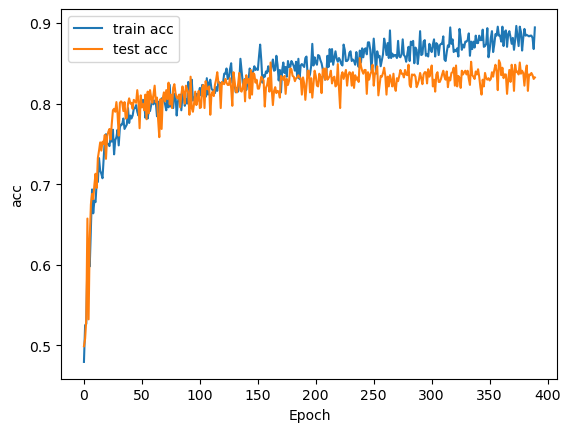

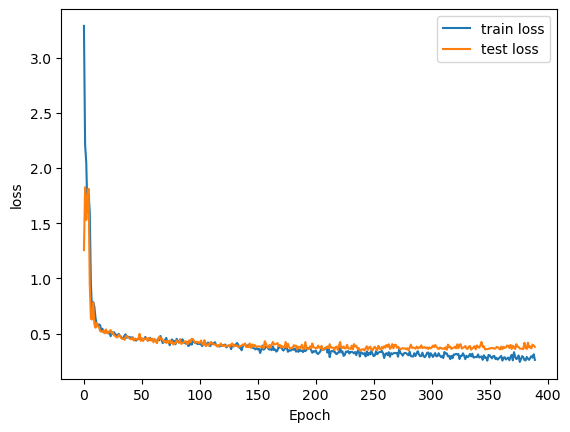

In [12]:
draw_acc_history(history)
draw_loss_history(history)
torch.save(history, f"./{config['model_name']}_history.ckpt")

In [13]:

model_best = config["model"].to(device)
model_best.load_state_dict(torch.load(f"./{config['model_name']}_best.ckpt"))
model_best.eval()


with torch.no_grad():

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= config["learning_rate"])

    batch_test_acc = []
    batch_test_loss = []
    
    for batch in tqdm(test_loader):
        features, labels = batch
        labels = labels.to(device)
        test_pred = model_best(features.to(device))
        loss = criterion(test_pred, labels.long()) 
        acc = (test_pred.argmax(dim= -1)== labels).float().mean()
        batch_test_acc.append(acc)
        batch_test_loss.append(loss.item())

    test_acc = sum(batch_test_acc) / len(batch_test_acc)
    test_loss = sum(batch_test_loss) / len(batch_test_loss)

    print(f"[ Test ] loss = {test_loss:.5f}, acc = {test_acc:.5f}")
        


  0%|          | 0/54 [00:00<?, ?it/s]

100%|██████████| 54/54 [00:00<00:00, 90.77it/s] 

[ Test ] loss = 0.34300, acc = 0.85648
